In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.linalg import svd
import scipy.linalg as la
from scipy.linalg import sqrtm
from numpy.linalg import matrix_power
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
N=1000 # the number of Berbnuli's trials

In [2]:
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def equal(a,b):
    if np.linalg.norm(a-b)<0.000001:
        return True
    return np.linalg.norm(a-b)
def bin_converter(number,n_qubits):
    binary=bin(number)[2::]
    while len(binary)<n_qubits:
        binary="0"+binary
    return binary
def get_psi(n_qubits):
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi
def R(delta,theta,phi):
    return np.array([[np.cos(delta/2)-1j*np.cos(theta)*np.sin(delta/2),-1j*np.sin(theta)*np.sin(delta/2)*np.exp(-1j*phi)],[-1j*np.sin(theta)*np.sin(delta/2)*np.exp(1j*phi),np.cos(delta/2)+1j*np.cos(theta)*np.sin(delta/2)]])
def get_e(a=-0.2,b=0.1):
    return random.random()*(b-a)+a
def get_trial(p):#bernuli test
    s=random.random()
    if s>p:
        return 0
    return 1
def Col(a): # вытягивание матрицы в столбец
    h=len(a)
    return a.reshape(-1,order='F').reshape((h**2,1))
def distribution_func(x,a=-0.2,b=0.1):
    if x>b:
        return 0
    elif x<a:
        return 0
    else:
        return 1/(b-a)

# Exercise 1

In [3]:
psi0=get_psi(1) # initial state preparation

In [4]:
#simulation with error
Bernuli=np.array([
    np.array([
    get_trial(
    np.abs(
        (R(
            get_e()*np.pi/10,np.pi/4,np.pi)@psi0)[0])**2) for i in range(N)]).sum()/N for j in range(N)])

In [5]:
#errorless simulation e=0
Bernuli1=np.array([
    np.array([
        get_trial(
            np.abs(
                (R(0,np.pi/4,np.pi)@psi0)
                [0])**2) for i in range(N)]).sum()/N for j in range(N)])

In [6]:
theory=np.abs((R(0,np.pi/4,np.pi)@psi0)[0])**2

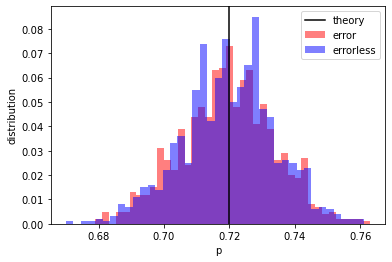

In [7]:
plt.hist(Bernuli,bins=40,weights=np.array([1/N for i in range(N)]),color='red',alpha=0.5,label="error")
plt.hist(Bernuli1,bins=40,weights=np.array([1/N for i in range(N)]),color="blue",alpha=0.5,label="errorless")
plt.axvline(x=theory, color='black', linestyle='-',label="theory")
plt.xlabel('p')
plt.ylabel('distribution')
plt.legend()
plt.show()

In [8]:
def get_chi(e,R=R):# obtaining chi
    e_R=Col(R(e*np.pi/10,np.pi/4,np.pi))
    return e_R@e_R.conjugate().T
def chi_mean(a=-0.2,b=0.1,N=N):
    return np.array([get_chi(a+i*(b-a)/N)*distribution_func(a+i*(b-a)/N)*(b-a)/N for i in range(1,N+1)]).sum(axis=0)
def anti_Col(a):
    return np.reshape(a,(int(np.sqrt(len(a))),int(np.sqrt(len(a)))),order='F')
def get_Kraus(chi):
    D,U=np.linalg.eig(chi)
    e_chi=U@np.sqrt(np.diag(D))
    return np.array([anti_Col(e_chi[:,i]) for i in range(len(e_chi))])
list_Kraus=get_Kraus(chi_mean())
rho=np.array([list_Kraus[i]@psi0@psi0.conjugate().T@list_Kraus[i].conjugate().T for i in range(len(list_Kraus))]).sum(axis=0)
state0=np.array([[1],[0]])
def Fidelity(psi,phi):
    return np.abs(psi.T.conjugate()@phi)**2

In [9]:
np.array([list_Kraus[i]@list_Kraus[i].T.conjugate() for i in range(len(list_Kraus))]).sum(axis=0) # Check Kraus condition

array([[9.99000000e-01+1.86190101e-19j, 4.58440081e-17-1.64409095e-18j],
       [4.58440081e-17+1.64409095e-18j, 9.99000000e-01+3.64976126e-23j]])

In [10]:
np.real(state0.conjugate().T@rho@state0)[0][0] #mean of p 

0.7185428753783761

# Exercise 2

In [11]:
n=8
psi0=get_psi(n) #initial state preparation
def H_er(a,b):
    return R(get_e(a,b)*np.pi/10,np.pi/4,np.pi)@H
def H_er_global(qubit,a,b,n=n):
    if qubit==1:
        gate=H_er(a,b)
    else:
        gate=np.eye(2,dtype="complex")
    for i in range(2,n+1):
        if i==qubit:
            gate=np.kron(gate,H_er(a,b))
        else:
            gate=np.kron(gate,np.eye(2,dtype="complex"))
    return gate
def C_R_k(target,control,k,n=n):
    gate=np.eye(2**n,dtype="complex")
    for i in range(2**n):
        if (bin_converter(i,n_qubits=n)[target-1]=="1" and bin_converter(i,n_qubits=n)[control-1]=="1"):
            gate[i][i]=np.exp(2j*np.pi/(2**k))
    return gate
def QFT(psi,a,b,n=n):
    gate=np.eye(2**n,dtype="complex")
    for qubit in range(1,n+1):
        gate=H_er_global(qubit,a,b,n=n)@gate
        for pair in range(qubit+1,n+1):
            gate=C_R_k(qubit,pair,pair-qubit+1,n=n)@gate
    return gate@psi
def swap_global(n):
    gate=np.zeros((2**n,2**n))
    for i in range(2**n):
        gate[i][int(bin_converter(i,n_qubits=n)[::-1],2)]=1
    return gate
def QFT_matrix(psi,n_qubits=n):
    w=np.exp(2*np.pi*1j/(2**n_qubits))
    matrix=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(2**n_qubits):
        for j in range(2**n_qubits):
            matrix[i][j]=w**(i*j)
    return swap_global(n_qubits)@matrix@psi/np.sqrt(2**n_qubits)
QFT_ideal=QFT_matrix(psi0)
e_list=np.array([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1])

In [12]:
QFT0=np.array([Fidelity(QFT(psi0,a=-e_list[0]/2,b=e_list[0]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [13]:
QFT1=np.array([Fidelity(QFT(psi0,a=-e_list[1]/2,b=e_list[1]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [14]:
QFT2=np.array([Fidelity(QFT(psi0,a=-e_list[2]/2,b=e_list[2]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [15]:
QFT3=np.array([Fidelity(QFT(psi0,a=-e_list[3]/2,b=e_list[3]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [16]:
QFT4=np.array([Fidelity(QFT(psi0,a=-e_list[4]/2,b=e_list[4]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [17]:
QFT5=np.array([Fidelity(QFT(psi0,a=-e_list[5]/2,b=e_list[5]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [18]:
QFT6=np.array([Fidelity(QFT(psi0,a=-e_list[6]/2,b=e_list[6]/2),QFT_ideal)[0][0] for i in range(int(N/2))])

In [19]:
QFT_means=np.array([QFT0.mean(),QFT1.mean(),QFT2.mean(),QFT3.mean(),QFT4.mean(),QFT5.mean(),QFT6.mean()])

In [20]:
low_quantile=np.array([np.quantile(QFT0,0.25),np.quantile(QFT1,0.25),np.quantile(QFT2,0.25),np.quantile(QFT3,0.25),np.quantile(QFT4,0.25),np.quantile(QFT5,0.25),np.quantile(QFT6,0.25)])
high_quantile=np.array([np.quantile(QFT0,0.75),np.quantile(QFT1,0.75),np.quantile(QFT2,0.75),np.quantile(QFT3,0.75),np.quantile(QFT4,0.75),np.quantile(QFT5,0.75),np.quantile(QFT6,0.75)])

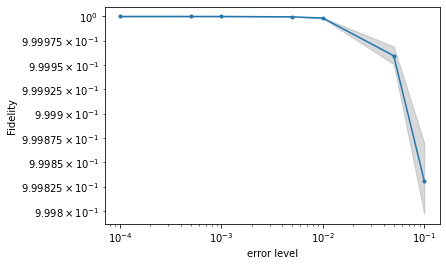

In [22]:
plt.plot(e_list,QFT_means,'.-')
plt.fill_between(e_list,low_quantile,high_quantile,color='gray',alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("error level")
plt.ylabel("Fidelity")
plt.show()